## Importing Libraries

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import dill
import datetime

## Importing Data

In [2]:
import pickle
pkl_file = "/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Data_Sets/Synthetic Data/Uncentered X/Bounded_Var_Time:2024-04-15 19:35:40, intercept:5,n_train:5000, n_test:1000, tensor_dimensions:[32 32], tensor_mode_ranks:[4 4], separation_rank:2.pkl"
file= open(pkl_file, 'rb')
data = pickle.load(file)
file.close()

X_train_Full = data[0]
print(data[0].shape)

Y_train_Full = data[1]
print(data[1].shape)

X_test_Full = data[2]
print(data[2].shape)

Y_test_Full = data[3]
print(data[3].shape)

B_tensored = data[4]
print(data[4].shape)

(5000, 32, 32)
(5000,)
(1000, 32, 32)
(1000,)
(32, 32)


## Setting up Global Parameters

### 1. Tensor Parameters

In [3]:
#importing path 
import sys
sys.path.append('/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Platforms for Experments/CodeFiles')

#parameters related to tensor

tensor_dimensions = np.array([32, 32])
tensor_mode_ranks = np.array([4, 4])
separation_rank = 2

### 2. Preprocessing Pipeline

In [4]:
n_train = 650
n_test = 100

#Subset X_train and Y_train
X_train = X_train_Full[0:(n_train),:,:]
Y_train = Y_train_Full[0:(n_train)]

#Subset X_test and Y_test
X_test = X_test_Full[0:(n_test),:,:]
Y_test = Y_test_Full[0:(n_test)]


#Preprocessing

# Reshape the 3D array to a 2D array where each row represents a sample
# The shape of the original 3D array is (n_samples, n_features_per_sample, n_dimensions)
# We reshape it to (n_samples, n_features_per_sample * n_dimensions)


X_train_2D = X_train.reshape(n_train, -1)
X_test_2D = X_test.reshape(n_test,-1)


# Initialize StandardScaler
scaler = StandardScaler(with_std = False) #standard scalar only

# Fit scaler on train data and transform train data
X_train_scaled = scaler.fit_transform(X_train_2D)
# Transform test data using the scaler fitted on train data
X_test_scaled = scaler.transform(X_test_2D)

# Reshape the scaled data back to 3D
X_train = X_train_scaled.reshape(n_train, tensor_dimensions[0],tensor_dimensions[1])
X_test  = X_test_scaled.reshape(n_test, tensor_dimensions[0],tensor_dimensions[1])

#average response value
Y_train_mean = np.mean(Y_train)
#Mean centering y_train and y_test
Y_train = Y_train - Y_train_mean


print("Sample mean for each feature (across samples):",scaler.mean_)
print("Sample variance for each feature (across samples):",scaler.var_)
print('Response Average:',Y_train_mean)


Sample mean for each feature (across samples): [4.99871322 4.98420917 5.00873521 ... 5.01840176 4.98600789 5.01023623]
Sample variance for each feature (across samples): None
Response Average: 83.56008733093063


In [5]:
# intializing the tensor object 
from LSR_Tensor_2D_v1 import LSR_tensor_dot

hypers = {'max_iter': 100, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank}

ranks = hypers['ranks']
separation_rank = hypers['separation_rank']
LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
need_intercept = False

lsr_tensor_CL = LSR_tensor_dot(shape = LSR_tensor_dot_shape, ranks = ranks, separation_rank = separation_rank, intercept = need_intercept)

#keeping a copy of the orginal object
import copy
lsr_tensor_SGD = copy.deepcopy(lsr_tensor_CL)
lsr_tensor_GD = copy.deepcopy(lsr_tensor_CL)

#regularization parameter

lambda1 = 50


intercept is not initialized


## Closed-Form Solver

In [6]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression_closed import lsr_bcd_regression
from optimization_closed import inner_product, R2, objective_function_vectorized

def train_test(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, B_tensored: np.ndarray,lsr_tensor_CL,lambda1, hypers,Y_train_mean, intercept = False):
  hypers['weight_decay'] = lambda1

  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_CL
  lsr_tensor, objective_function_values = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')

  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean


  print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  print("Y Test Predicted: ", Y_test_predicted.flatten())
  print("Y Test Actual: ", Y_test.flatten())

  return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values


In [7]:
#hyper parameters

normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values = train_test(X_train, Y_train, X_test, Y_test, B_tensored,lsr_tensor_CL, lambda1, hypers, Y_train_mean,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/Tensor_Method/Finding Lamda for Test/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("Alpha chosen for model: ", lambda1)
print("Test Normalized Estimation Error: ", normalized_estimation_error)
print("Test NMSE Loss: ", test_nmse_loss)
print("Test R2 Loss: ", test_R2_loss)
print("Test Correlation: ", test_correlation)

#with open(pkl_file, "wb") as file:
#  dill.dump((X_train_Full, Y_train_Full, X_test_Full, Y_test_Full, B_tensored, lambda1, validation_normalized_estimation_error, validation_nmse_losses, validation_correlations, validation_R2_scores, objective_function_information, normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values), file)

Separable Function
Objective Function Value: 6996529.963838284
Separable Function
Separable Function
Separable Function


Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Fu

## Gradient Descent 

In [8]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression_gd import lsr_bcd_regression
from optimization import inner_product, R2, objective_function_vectorized

def train_test_gd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_GD,B_tensored = None,intercept = False):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_GD
  lsr_tensor, objective_function_values, gradient_values = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  #print("Y Test Predicted: ", Y_test_predicted.flatten())
  #print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values



In [9]:
learning_rate = 0.000003
epochs = 100
batch_size = 32

hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size}

normalized_estimation_error_GD, test_nmse_loss_GD, test_R2_loss_GD, test_correlation_GD, objective_function_values_GD,gradient_values_GD = train_test_gd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_GD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/Tensor_Method/Finding Lamda for Test/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("GD_Alpha chosen for model: ", lambda1)
print("GD_Test Normalized Estimation Error: ", normalized_estimation_error_GD)
print("GD_Test NMSE Loss: ", test_nmse_loss_GD)
print("GD_Test R2 Loss: ", test_R2_loss_GD)
print("GD_Test Correlation: ", test_correlation_GD)

#with open(pkl_file, "wb") as file:
#  dill.dump((X_train_Full, Y_train_Full, X_test_Full, Y_test_Full, B_tensored, lambda1, normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD), file)

Separable Function
Objective Function Value: 6996529.963838284
Value of t is: 1.1208287701526185e-05
Gradient Norm for linear.weight: 303518.71875
Value of t is: 1.2423159109538253e-05
Gradient Norm for linear.weight: 135593.828125
Value of t is: 1.182819718519583e-05
Gradient Norm for linear.weight: 91551.875
Value of t is: 1.2996056161336965e-05
Gradient Norm for linear.weight: 67451.234375
Value of t is: 1.2010991872144243e-05
Gradient Norm for linear.weight: 58725.515625
Value of t is: 1.2989964218736114e-05
Gradient Norm for linear.weight: 49496.1484375
Value of t is: 1.1935034782755821e-05
Gradient Norm for linear.weight: 46554.83984375
Value of t is: 1.288269702775752e-05
Gradient Norm for linear.weight: 41151.71875
Value of t is: 1.1850474620604964e-05
Gradient Norm for linear.weight: 39935.3828125
Value of t is: 1.2799929192257482e-05
Gradient Norm for linear.weight: 36085.08203125
Value of t is: 1.179494362708438e-05
Gradient Norm for linear.weight: 35541.10546875
Value of t 

## Stochastic Solver

In [10]:
from sklearn.linear_model import Ridge
import numpy as np
from LSR_Tensor_2D_v1 import LSR_tensor_dot
from lsr_bcd_regression import lsr_bcd_regression
from optimization import inner_product, R2, objective_function_vectorized

def train_test_sgd(X_train: np.ndarray, Y_train: np.ndarray, X_test: np.ndarray, Y_test: np.ndarray, lambda1, hypers,Y_train_mean,lsr_tensor_SGD,B_tensored = None,intercept = False):
  hypers['weight_decay'] = lambda1

  
  #Define LSR Tensor Hyperparameters
  ranks = hypers['ranks']
  separation_rank = hypers['separation_rank']
  LSR_tensor_dot_shape = tuple(X_train.shape)[1:]
  need_intercept = intercept

  #Construct LSR Tensor
  lsr_tensor = lsr_tensor_SGD
  lsr_tensor, objective_function_values, gradient_values = lsr_bcd_regression(lsr_tensor, X_train, Y_train, hypers,intercept = need_intercept)
  expanded_lsr = lsr_tensor.expand_to_tensor()
  expanded_lsr = np.reshape(expanded_lsr, X_train[0].shape, order = 'F')
  print(expanded_lsr.shape)
  Y_test_predicted = inner_product(np.transpose(X_test, (0, 2, 1)), expanded_lsr.flatten(order ='F')) + lsr_tensor.b + Y_train_mean

  print('---------------------------Testing with Best Lambda------------------------------')
  #print(f"Y_test_predicted: {Y_test_predicted.flatten()}, Y_test: {Y_test.flatten()}")
  test_nmse_loss = np.sum(np.square((Y_test_predicted.flatten() - Y_test.flatten()))) / np.sum(np.square(Y_test.flatten()))
  if B_tensored is not None:
    normalized_estimation_error = ((np.linalg.norm(expanded_lsr - B_tensored)) ** 2) /  ((np.linalg.norm(B_tensored)) ** 2)
  test_R2_loss = R2(Y_test.flatten(), Y_test_predicted.flatten())
  test_correlation = np.corrcoef(Y_test_predicted.flatten(), Y_test.flatten())[0, 1]

  #print("Y Test Predicted: ", Y_test_predicted.flatten())
  #print("Y Test Actual: ", Y_test.flatten())

  if B_tensored is not None:
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values
  else:
    normalized_estimation_error = np.inf
    return normalized_estimation_error, test_nmse_loss, test_R2_loss, test_correlation, objective_function_values,gradient_values



In [11]:
learning_rate = 0.000003
epochs = 100
batch_size = 32

hypers = {'max_iter': 50, 'threshold': 1e-4, 'ranks': tuple(tensor_mode_ranks), 'separation_rank': separation_rank,'learning_rate':learning_rate,'epochs':epochs,'batch_size': batch_size}

normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD,gradient_values_SGD = train_test_sgd(X_train, Y_train, X_test, Y_test, lambda1, hypers, Y_train_mean,lsr_tensor_SGD,B_tensored,intercept= False)

#Get current time and store in variable
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
max_iter = hypers['max_iter']
pkl_file = f"/Users/lakrama/Neuro Project Codes/LSR-Tensor-Ridge-Regression/Closed_Form_Solver/Experimental Results/Tensor_Method/Finding Lamda for Test/ExecutionTime_intercept_5_{formatted_time}, n_train_{n_train},n_test_{n_test}, tensor_dimensions:{tensor_dimensions}, tensor_mode_= ranks:{tensor_mode_ranks}, separation_rank:{separation_rank}, max_iter={max_iter}.pkl"

print("Error Report on Testing _ With best Lambda")
print("SGD_Alpha chosen for model: ", lambda1)
print("SGD_Test Normalized Estimation Error: ", normalized_estimation_error_SGD)
print("SGD_Test NMSE Loss: ", test_nmse_loss_SGD)
print("SGD_Test R2 Loss: ", test_R2_loss_SGD)
print("SGD_Test Correlation: ", test_correlation_SGD)

#with open(pkl_file, "wb") as file:
#  dill.dump((X_train_Full, Y_train_Full, X_test_Full, Y_test_Full, B_tensored, lambda1, normalized_estimation_error_SGD, test_nmse_loss_SGD, test_R2_loss_SGD, test_correlation_SGD, objective_function_values_SGD), file)

Separable Function
Objective Function Value: 6996529.963838284
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separable Function
Separa

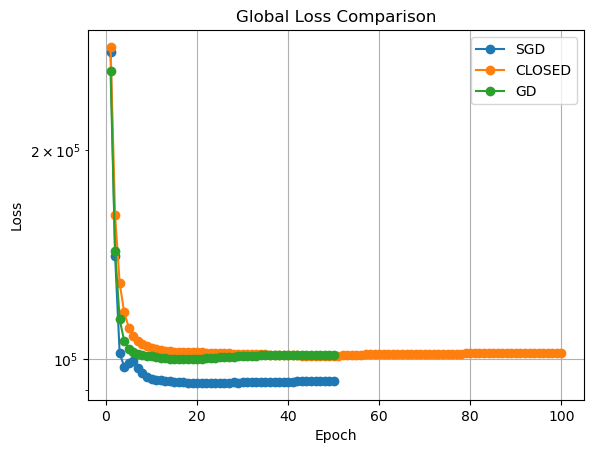

Final Objective Function Value CLOSED: 101935.67457851353
Final Objective Function Value SGD: 92662.60022182448
Final Objective Function Value GD: 101274.05663774045


In [12]:
import matplotlib.pyplot as plt

plt.figure()

# Plotting SGD
plt.plot(range(1, len(objective_function_values_SGD) + 1), objective_function_values_SGD[:, 1, 2], label='SGD',marker = 'o')

# Plotting CLOSED
plt.plot(range(1, len(objective_function_values) + 1), objective_function_values[:, 1, 2], label='CLOSED',marker = 'o')

# Plotting GD
plt.plot(range(1, len(objective_function_values_GD) + 1), objective_function_values_GD[:, 1, 2], label='GD',marker = 'o')

# Setting the title and labels
plt.title('Global Loss Comparison')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Adding a legend to distinguish the two plots
plt.legend()

# Display the plot
plt.show()

print('Final Objective Function Value CLOSED:',objective_function_values[-1,1,2])
print('Final Objective Function Value SGD:',objective_function_values_SGD[-1,1,2])
print('Final Objective Function Value GD:',objective_function_values_GD[-1,1,2])